# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [1]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch, torch.nn as nn

%load_ext autoreload
%autoreload 2


In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [ ]:
from src.utils_io import set_seeds, get_device

RUN = {
    "seed": 42,
    "device": get_device(),
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
}

set_seeds(RUN["seed"])
print(RUN)

{'seed': 42, 'device': device(type='mps'), 'timestamp': '2025-10-26_16-31-52'}


In [5]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [6]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [7]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)


for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (721, 64, 161), dtype: float32
y        | shape: (721,), dtype: int64, min/max: 0/1
subjects | shape: (721,), dtype: int32, min/max: 1/45
runs     | shape: (721,), dtype: int32, min/max: 4/12


In [ ]:
SFREQ = 160  # Hz

n_ch, n_t  = X.shape[1], X.shape[2]
n_classes  = int(np.unique(y).size)
classes_   = np.unique(y)



In [8]:
# baseline_acc = eval_with_preproc(X, y, subjects, make_eegnet, preproc_pair_fn=None, n_splits=5, plot_curves=True)
# summarize(baseline_acc, "EEGNet baseline (no preproc)")

### Test with bandpassed data

In [9]:
# def bp_8_30_pair(Xtr, Xte, l_freq=8., h_freq=30., sfreq=SFREQ):
#     # reshape to (N*C, T) for faster filtering, then back
#     def _bp(X):
#         NC, T = X.shape[0]*X.shape[1], X.shape[2]
#         X2 = np.ascontiguousarray(X.reshape(NC, T), dtype=np.float64)
#         Xf = mne.filter.filter_data(X2, sfreq=sfreq, l_freq=l_freq, h_freq=h_freq,
#                                     method='fir', verbose=False)
#         return Xf.reshape(X.shape).astype(np.float32, copy=False)
#     return _bp(Xtr), _bp(Xte)

In [10]:
# #momo
# baseline_acc_bp = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                             preproc_pair_fn=bp_8_30_pair, n_splits=5)
# summarize(baseline_acc_bp, "EEGNet + band-pass 8–30Hz")

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6338       0.6638        0.6771  0.0005  0.9689
      2        0.5773       0.7328        0.6596  0.0005  0.9199
      3        0.5281       0.7069        0.6385  0.0005  0.9219
      4        0.5074       0.7328        0.6155  0.0005  0.9305
      5        0.4726       0.7328        0.5971  0.0005  0.9344
      6        0.4703       0.7328        0.5841  0.0005  0.9266
      7        0.4363       0.7500        0.5701  0.0005  0.9432
      8        0.4328       0.7414        0.5552  0.0005  0.9837
      9        0.4078       0.7500        0.5423  0.0005  0.9402
     10        0.4091       0.7414        0.5281  0.0005  0.9130
     11        0.3989       0.7328        0.5129  0.0005  0.9650
     12        0.3925       0.7328        0.5013  0.0005  0.9458
     13        0.3749       0.7328        0.4879  0.0005  0.9090
     14        0.3783    

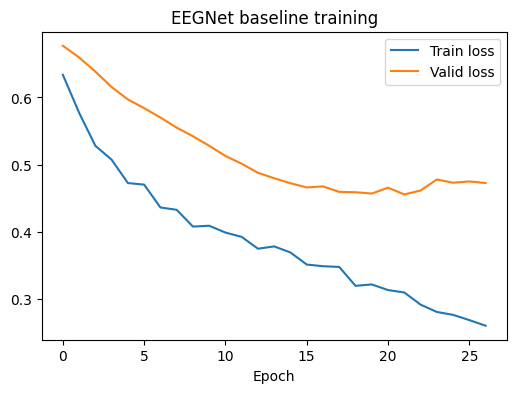

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7118       0.6121        0.6901  0.0005  0.9299
      2        0.6400       0.6466        0.6839  0.0005  0.9104
      3        0.6125       0.6466        0.6759  0.0005  0.9118
      4        0.5808       0.6552        0.6645  0.0005  0.9130
      5        0.5578       0.6638        0.6501  0.0005  0.9447
      6        0.5346       0.6724        0.6374  0.0005  0.9435
      7        0.5238       0.6897        0.6225  0.0005  0.9043
      8        0.5001       0.6983        0.6095  0.0005  0.8998
      9        0.4818       0.7069        0.5967  0.0005  0.8989
     10        0.4761       0.6983        0.5829  0.0005  0.8968
     11        0.4521       0.7155        0.5704  0.0005  0.9102
     12        0.4470       0.7069        0.5587  0.0005  0.9132
     13        0.4369       0.7155        0.5482  0.0005  0.9236
     14        0.4168    

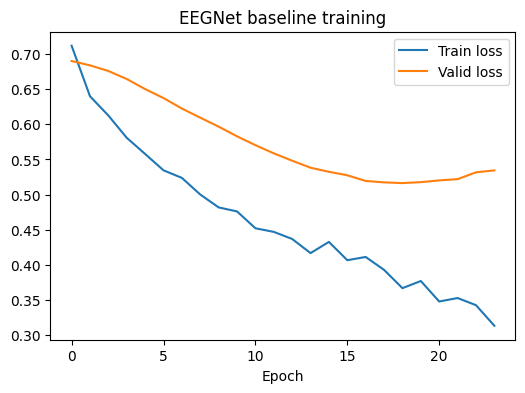

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6901       0.7586        0.6851  0.0005  0.9169
      2        0.6201       0.7845        0.6709  0.0005  0.9079
      3        0.5615       0.8276        0.6488  0.0005  0.9028
      4        0.5330       0.8103        0.6218  0.0005  0.9080
      5        0.5156       0.8190        0.5976  0.0005  0.9079
      6        0.4872       0.8103        0.5786  0.0005  0.9056
      7        0.4795       0.8103        0.5621  0.0005  0.9182
      8        0.4628       0.7931        0.5476  0.0005  0.9176
      9        0.4600       0.8448        0.5352  0.0005  0.9867
     10        0.4470       0.8362        0.5182  0.0005  0.9526
     11        0.4342       0.8534        0.5031  0.0005  0.9437
     12        0.4292       0.8621        0.4892  0.0005  0.9406
     13        0.4167       0.8534        0.4757  0.0005  0.9429
     14        0.4059    

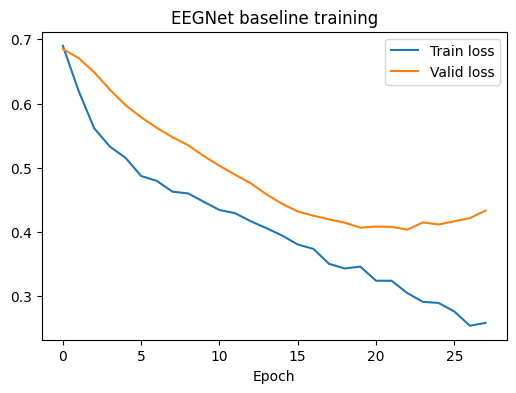

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6542       0.6638        0.6860  0.0005  0.9809
      2        0.5803       0.6810        0.6761  0.0005  0.9548
      3        0.5295       0.7155        0.6610  0.0005  0.9392
      4        0.4999       0.7155        0.6421  0.0005  0.9651
      5        0.4682       0.7241        0.6268  0.0005  0.9409
      6        0.4398       0.7328        0.6102  0.0005  0.9536
      7        0.4290       0.7414        0.5934  0.0005  0.9543
      8        0.4144       0.7672        0.5770  0.0005  0.9590
      9        0.4000       0.7672        0.5621  0.0005  0.9182
     10        0.3785       0.7586        0.5467  0.0005  0.9254
     11        0.3709       0.7759        0.5328  0.0005  0.9460
     12        0.3468       0.7586        0.5207  0.0005  0.9297
     13        0.3490       0.7759        0.5041  0.0005  0.9365
     14        0.3291    

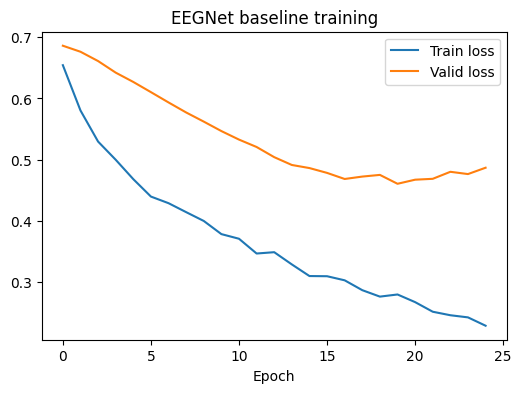

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6787       0.5948        0.6876  0.0005  0.9508
      2        0.6011       0.7500        0.6730  0.0005  0.9328
      3        0.5252       0.7586        0.6529  0.0005  0.9363
      4        0.5055       0.7672        0.6325  0.0005  0.9376
      5        0.4764       0.7500        0.6175  0.0005  0.9283
      6        0.4604       0.7586        0.6006  0.0005  0.9226
      7        0.4455       0.7586        0.5873  0.0005  0.9356
      8        0.4311       0.7241        0.5736  0.0005  0.9669
      9        0.4145       0.7155        0.5613  0.0005  0.9379
     10        0.3917       0.7241        0.5517  0.0005  0.9305
     11        0.3853       0.7328        0.5370  0.0005  0.9483
     12        0.3722       0.7328        0.5265  0.0005  0.9372
     13        0.3665       0.7328        0.5225  0.0005  0.9341
     14        0.3683    

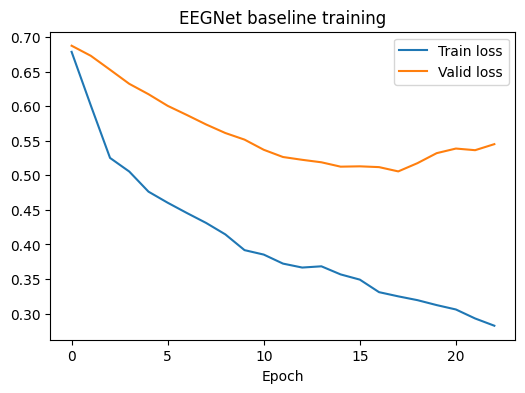

EEGNet + per-trial z-score     acc 0.771±0.074 | κ 0.542±0.149


In [11]:
baseline_acc_ztrial = eval_with_preproc(X, y, subjects, 
                                        build_module=lambda: make_eegnet(),
                                        preproc_pair_fn=zscore_per_trial_pair, 
                                        n_splits=5,
                                        plot_curves=True,)
summarize(baseline_acc_ztrial, "EEGNet + per-trial z-score")


In [12]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.6896551724137931, 'kappa': 0.3747005270723527},
 {'fold': 1, 'acc': 0.9097222222222222, 'kappa': 0.8194444444444444},
 {'fold': 2, 'acc': 0.7708333333333334, 'kappa': 0.5423728813559322},
 {'fold': 3, 'acc': 0.7430555555555556, 'kappa': 0.48611111111111116},
 {'fold': 4, 'acc': 0.7430555555555556, 'kappa': 0.48729792147806006}]

In [13]:
# baseline_acc_foldstd = eval_with_preproc(X, y, subjects, build_module=lambda: make_eegnet(),
#                                  preproc_pair_fn=foldwise_channel_standardize_pair, n_splits=5)
# summarize(baseline_acc_foldstd, "EEGNet + foldwise channel z-score")


### fine hyperparameter tuning

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6711       0.6466        0.6868  0.0005  1.0916
      2        0.5782       0.7241        0.6722  0.0005  1.1005
      3        0.5089       0.7241        0.6500  0.0005  1.1041
      4        0.4827       0.7414        0.6297  0.0005  1.1121
      5        0.4583       0.7500        0.6096  0.0005  1.1090
      6        0.4514       0.7586        0.5968  0.0005  1.1010
      7        0.4147       0.7672        0.5837  0.0005  1.1150
      8        0.4016       0.7414        0.5692  0.0005  1.1016
      9        0.4144       0.7414        0.5577  0.0005  1.1136
     10        0.3946       0.7586        0.5375  0.0005  1.1000
     11        0.3736       0.7586        0.5227  0.0005  1.1293
     12        0.3764       0.7586        0.5122  0.0005  1.0981
     13        0.3639       0.7759        0.5002  0.0005  1.1075
     14        0.3603    

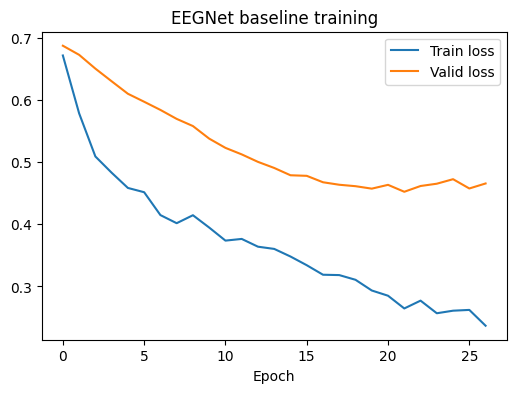

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6586       0.6552        0.6871  0.0005  1.1378
      2        0.5944       0.7069        0.6786  0.0005  1.1074
      3        0.5698       0.7069        0.6655  0.0005  1.1584
      4        0.5259       0.6897        0.6496  0.0005  1.1909
      5        0.5103       0.6810        0.6346  0.0005  1.1822
      6        0.4825       0.6897        0.6212  0.0005  1.1356
      7        0.4955       0.6810        0.6116  0.0005  1.1066
      8        0.4686       0.6983        0.5988  0.0005  1.1182
      9        0.4704       0.7069        0.5878  0.0005  1.1352
     10        0.4530       0.7241        0.5747  0.0005  1.1310
     11        0.4404       0.7328        0.5640  0.0005  1.1188
     12        0.4360       0.7155        0.5543  0.0005  1.1189
     13        0.4204       0.7241        0.5414  0.0005  1.1290
     14        0.4225    

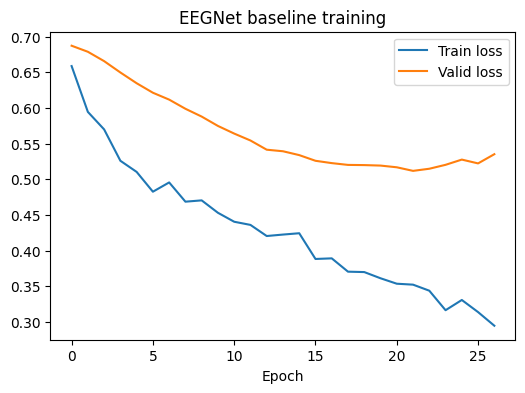

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7031       0.5603        0.6900  0.0005  1.1362
      2        0.6417       0.7069        0.6806  0.0005  1.1102
      3        0.5748       0.7586        0.6597  0.0005  1.1381
      4        0.5264       0.7586        0.6335  0.0005  1.1424
      5        0.4960       0.7672        0.6059  0.0005  1.1252
      6        0.4702       0.7845        0.5854  0.0005  1.1600
      7        0.4546       0.8103        0.5698  0.0005  1.1415
      8        0.4388       0.8103        0.5573  0.0005  1.1273
      9        0.4302       0.8103        0.5426  0.0005  1.1186
     10        0.4056       0.8103        0.5253  0.0005  1.1144
     11        0.4109       0.7931        0.5106  0.0005  1.1299
     12        0.3939       0.7845        0.4952  0.0005  1.1010
     13        0.3805       0.7931        0.4762  0.0005  1.1011
     14        0.3611    

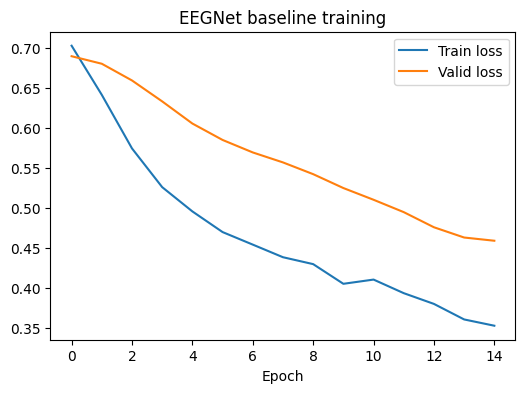

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7131       0.6638        0.6888  0.0005  1.1370
      2        0.6120       0.6897        0.6801  0.0005  1.1108
      3        0.5298       0.6810        0.6640  0.0005  1.1178
      4        0.4802       0.7069        0.6425  0.0005  1.1175
      5        0.4569       0.7241        0.6219  0.0005  1.1450
      6        0.4252       0.7241        0.6054  0.0005  1.1354
      7        0.4148       0.7241        0.5911  0.0005  1.1215
      8        0.3984       0.7241        0.5776  0.0005  1.1248
      9        0.3843       0.7414        0.5642  0.0005  1.1234
     10        0.3648       0.7155        0.5551  0.0005  1.1165


In [ ]:
import numpy as np
import pandas as pd
from itertools import product

grid = {
    "F1":        [8, 16],
    "D":         [2, 4],
    "drop":      [0.25, 0.5],
    "epochs":    [30],      # adjust only if needed
    "batch":     [32],      # keep fixed for now to reduce variance
}

results = []
for F1, D, drop, epochs, batch in product(*grid.values()):
    rows = eval_with_preproc(
        X, y, subjects,
        build_module=lambda: make_eegnet(F1=F1, D=D, drop=drop),
        preproc_pair_fn=zscore_per_trial_pair,
        n_splits=5,
        plot_curves=True,
    )
    accs   = [r["acc"] for r in rows]
    kappas = [r["kappa"] for r in rows]
    results.append({
        "F1": F1, "D": D, "drop": drop, "epochs": epochs, "batch": batch,
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "kappa_mean": np.mean(kappas), "kappa_std": np.std(kappas),
    })

tune_df = pd.DataFrame(results).sort_values("acc_mean", ascending=False).reset_index(drop=True)
display(tune_df.head(10))  # top configs
best = tune_df.iloc[0].to_dict()
print("Best (coarse):", best)


In [ ]:
'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7517633674630262, 'acc_std': 0.05274310656010483, 'kappa_mean': 0.5029765838789825, 'kappa_std': 0.10538937939036418}

In [ ]:
FIGS

PosixPath('/Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs')

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6922       0.6979        0.6780  0.0005  2.0827
      2        0.6240       0.7702        0.6478  0.0005  2.1224
      3        0.5761       0.7617        0.6059  0.0005  401.1290
      4        0.5326       0.7532        0.5675  0.0005  2.4081
      5        0.5183       0.7489        0.5394  0.0005  2.1603
      6        0.5030       0.7532        0.5189  0.0005  2.1923
      7        0.4962       0.7489        0.4998  0.0005  2.0723
      8        0.4717       0.7532        0.4874  0.0005  2.3732
      9        0.4794       0.7574        0.4755  0.0005  2.0023
     10        0.4650       0.7489        0.4719  0.0005  1.9960
     11        0.4636       0.7574        0.4743  0.0005  2.0199
     12        0.4491       0.7574        0.4693  0.0005  2.1664
     13        0.4591       0.7574        0.4733  0.0005  2.0550
     14        0.4479  

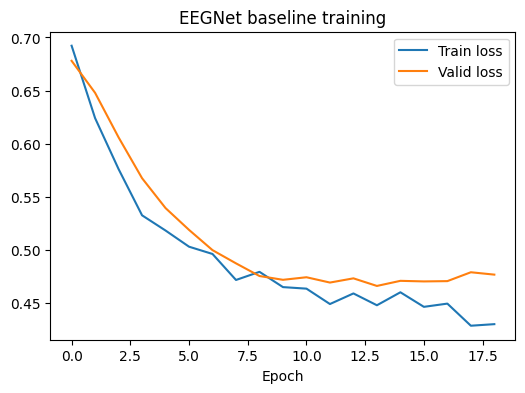

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold0_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6561       0.7362        0.6783  0.0005  2.0621
      2        0.5824       0.7532        0.6423  0.0005  2.0277
      3        0.5432       0.7532        0.6009  0.0005  2.0457
      4        0.5320       0.7702        0.5776  0.0005  2.0469
      5        0.5333       0.7830        0.5540  0.0005  2.1352
      6        0.5010       0.7915        0.5339  0.0005  2.0822
      7        0.5019       0.7915        0.5205  0.0005  1.9930
      8        0.4889       0.7957        0.5055  0.0005  2.0622
      9        0.4846       0.7915        0.4982  0.0005  2.0058
     10        0.4707       0.7872        0.4871  0.0005  1.9869
     11        0.4729       0.7702        0.4819  0.0005  1.9762
     12        0.4571       0.7745     

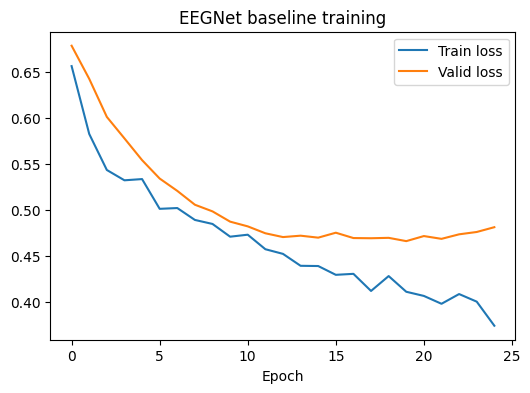

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold1_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6866       0.6511        0.6885  0.0005  1.9961
      2        0.6295       0.6894        0.6689  0.0005  1.9934
      3        0.5619       0.7149        0.6283  0.0005  2.0320
      4        0.5083       0.7234        0.5914  0.0005  1.9836
      5        0.4966       0.7277        0.5638  0.0005  2.0752
      6        0.4897       0.7447        0.5520  0.0005  2.0260
      7        0.4938       0.7362        0.5396  0.0005  1.9962
      8        0.4871       0.7447        0.5321  0.0005  2.0369
      9        0.4722       0.7532        0.5277  0.0005  1.9772
     10        0.4593       0.7447        0.5226  0.0005  1.9945
     11        0.4459       0.7532        0.5201  0.0005  2.0321
     12        0.4498       0.7660     

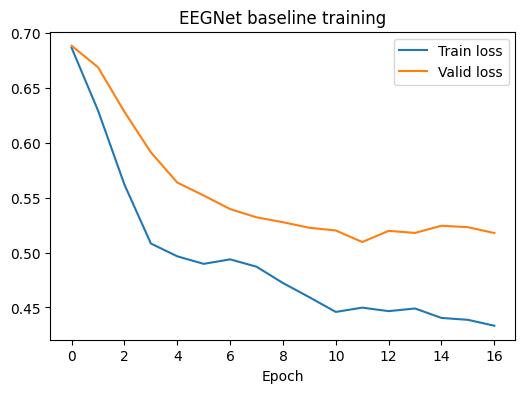

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold2_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7033       0.5745        0.6897  0.0005  2.0367
      2        0.6454       0.6383        0.6742  0.0005  2.0055
      3        0.5765       0.6638        0.6407  0.0005  2.0312
      4        0.5465       0.6723        0.6090  0.0005  2.0046
      5        0.5266       0.7021        0.5880  0.0005  2.0542
      6        0.5324       0.7021        0.5743  0.0005  2.0228
      7        0.5161       0.7021        0.5651  0.0005  2.0506
      8        0.5061       0.6979        0.5544  0.0005  2.0553
      9        0.5045       0.7149        0.5454  0.0005  2.0493
     10        0.5032       0.7064        0.5363  0.0005  2.0056
     11        0.4825       0.6979        0.5404  0.0005  2.0714
     12        0.4829       0.7021     

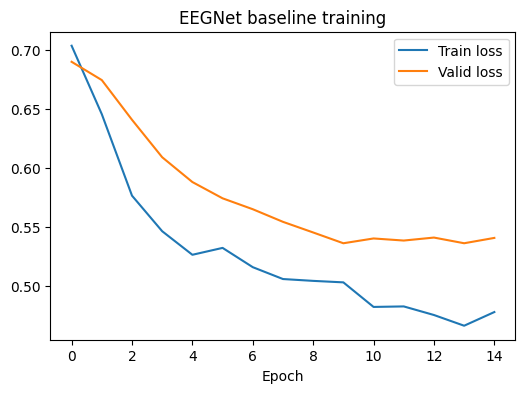

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold3_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7035       0.6553        0.6887  0.0005  2.0196
      2        0.6531       0.7149        0.6715  0.0005  1.9889
      3        0.6148       0.7319        0.6361  0.0005  1.9683
      4        0.5742       0.7191        0.5993  0.0005  1.9851
      5        0.5573       0.7106        0.5816  0.0005  2.0758
      6        0.5432       0.7149        0.5678  0.0005  2.0398


In [ ]:
best_rows = eval_with_preproc(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=int(best["F1"]), D=int(best["D"]), drop=float(best["drop"])),
    preproc_pair_fn=zscore_per_trial_pair,
    n_splits=5,
    plot_curves=True,
    saveFigs=True,
    filepath=FIGS
)
summarize(best_rows, "EEGNet (best params) + per-trial z-score")


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import numpy as np
import pandas as pd

def loso_final_eval(X, y, subjects, build_module, preproc_pair_fn, label="EEGNet LOSO"):
    """
    Leave-One-Subject-Out evaluation.
    X : (N, C, T)
    y : (N,)
    subjects : (N,) array of subject IDs
    build_module : function that returns a fresh EEG model
    preproc_pair_fn : function(X_train, X_test) -> (X_train_p, X_test_p)
    """
    unique_subs = np.unique(subjects)
    rows = []

    for sub in unique_subs:
        print(f"\n🧠 Testing on subject {sub}...")
        tr_idx = np.where(subjects != sub)[0]
        te_idx = np.where(subjects == sub)[0]

        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # preprocessing (safe: uses only train stats)
        Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        # build and train
        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, ytr)

        # predict on test subject
        yhat = clf.predict(Xte_p)
        acc = accuracy_score(yte, yhat)
        kappa = cohen_kappa_score(yte, yhat)

        rows.append(dict(sub=sub, acc=acc, kappa=kappa, n_test=len(yte)))
        print(f"   acc={acc:.3f}, κ={kappa:.3f}")

    df = pd.DataFrame(rows)
    print(f"\n{label}: acc {df.acc.mean():.3f}±{df.acc.std():.3f} | κ {df.kappa.mean():.3f}±{df.kappa.std():.3f}")
    return df


In [ ]:
# Final hold-out per subject (LOSO)
df_loso = loso_final_eval(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=8, D=2, drop=0.25),
    preproc_pair_fn=zscore_per_trial_pair,
    label="EEGNet + per-trial z-score (LOSO final test)"
)



🧠 Testing on subject 1...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5627       0.7509        0.5254  0.0100  2.3966
      2        0.5045       0.7474        0.5130  0.0100  2.3957
      3        0.4898       0.7235        0.5444  0.0100  2.3931
      4        0.4698       0.7406        0.5290  0.0100  2.5476
      5        0.4419       0.7270        0.5649  0.0100  2.3534
      6        0.4425       0.7065        0.6060  0.0100  2.3783
Stopping since valid_loss has not improved in the last 5 epochs.
   acc=1.000, κ=1.000

🧠 Testing on subject 2...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5663       0.7569        0.4879  0.0100  2.4632
      2        0.5162       0.7500        0.4897  0.0100  2.3281
      3        0.5141       0.7639        0.4984  0.0100  2.3431
      4       

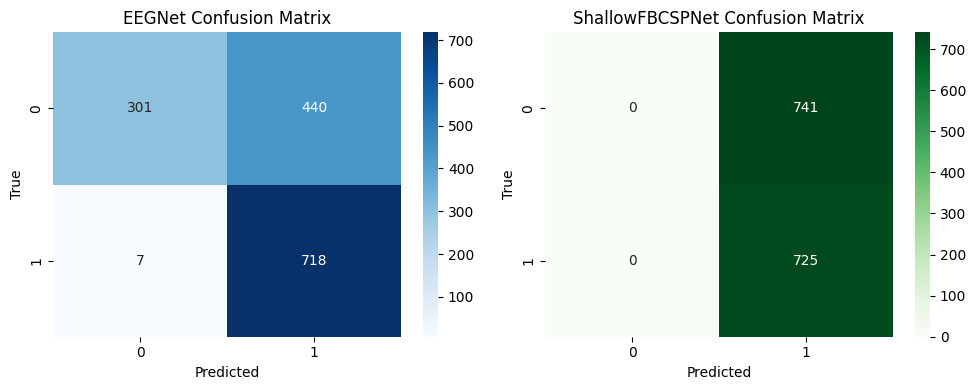

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [ ]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()
